<a href="https://colab.research.google.com/github/pergazuz/Leukemia-Classification-based-on-Microscopic-Images/blob/main/CPE352_Project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data from kaggle

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/colab"

In [3]:
#changing the working directory
%cd /content
#Check the present working directory using pwd command
!kaggle datasets download -d andrewmvd/leukemia-classification

/content
100% 866M/867M [00:43<00:00, 14.9MB/s]
100% 867M/867M [00:43<00:00, 20.9MB/s]


In [4]:
!unzip /content/leukemia-classification.zip  && /content/leukemia-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_6_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_7_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_1_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_2_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_3_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_1_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_2_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_3_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_4_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_5_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_6_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_7_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/

# Import lib

In [5]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


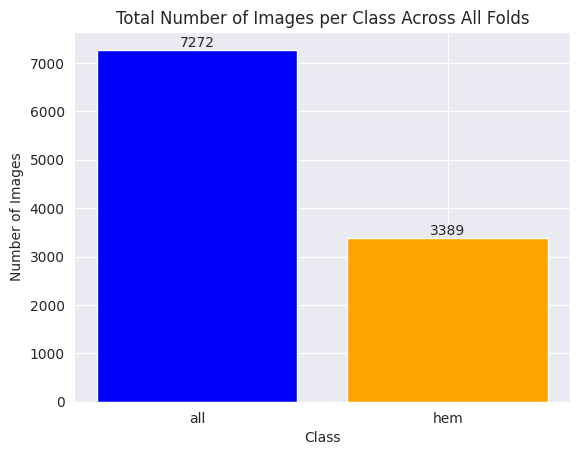

In [12]:
# Define the base directory for training data
base_dir = "/content/C-NMC_Leukemia/training_data"

# Initialize a dictionary to hold the count of images in each class across all folds
class_counts = {'all': 0, 'hem': 0}

# Loop through each fold and add the counts to the class_counts dictionary
for fold in ['fold_0', 'fold_1', 'fold_2']:
    fold_path = os.path.join(base_dir, fold)
    for class_name in ['all', 'hem']:
        class_path = os.path.join(fold_path, class_name)
        num_images = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
        class_counts[class_name] += num_images

# Plotting
fig, ax = plt.subplots()

# Set of different colors for the bars
colors = ['blue', 'orange']

# Plot the counts for each class
ax.bar(class_counts.keys(), class_counts.values(), color=colors)

# Adding the count above each bar
for i, (class_name, count) in enumerate(class_counts.items()):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Total Number of Images per Class Across All Folds')

# Show the plot
plt.show()

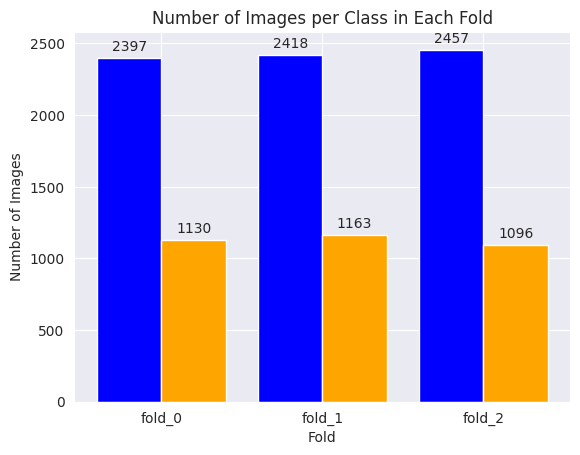

In [11]:
# Define the base directory for training data
base_dir = "/content/C-NMC_Leukemia/training_data"

# Initialize a dictionary to hold the count of images for each fold
fold_counts = {fold: {'all': 0, 'hem': 0} for fold in ['fold_0', 'fold_1', 'fold_2']}

# Loop through each fold
for fold in fold_counts:
    # Define the path for the current fold
    fold_path = os.path.join(base_dir, fold)

    # Loop through each class in the current fold
    for class_name in ['all', 'hem']:
        # Define the path for the current class
        class_path = os.path.join(fold_path, class_name)

        # Count the number of image files in the current class directory
        num_images = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])

        # Update the count for the current class in the current fold
        fold_counts[fold][class_name] = num_images

# Plotting
# Define the figure and axes
fig, ax = plt.subplots()

# Set of different colors for the bars
colors = ['blue', 'orange']

# Loop over each fold and plot the counts for each class
bars = []  # List to keep track of the bar containers
for i, (fold, counts) in enumerate(fold_counts.items()):
    bar = ax.bar([i - 0.2, i + 0.2], counts.values(), width=0.4, label=f"{fold}", color=colors)
    bars.append(bar)

# Setting the x-ticks to be the class names, and enabling the legend
ax.set_xticks(range(len(fold_counts)))
ax.set_xticklabels(fold_counts.keys())


# Adding labels and title
plt.xlabel('Fold')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Each Fold')

# Adding the count above each bar
for bar_container in bars:
    for bar in bar_container:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Show the plot
plt.show()

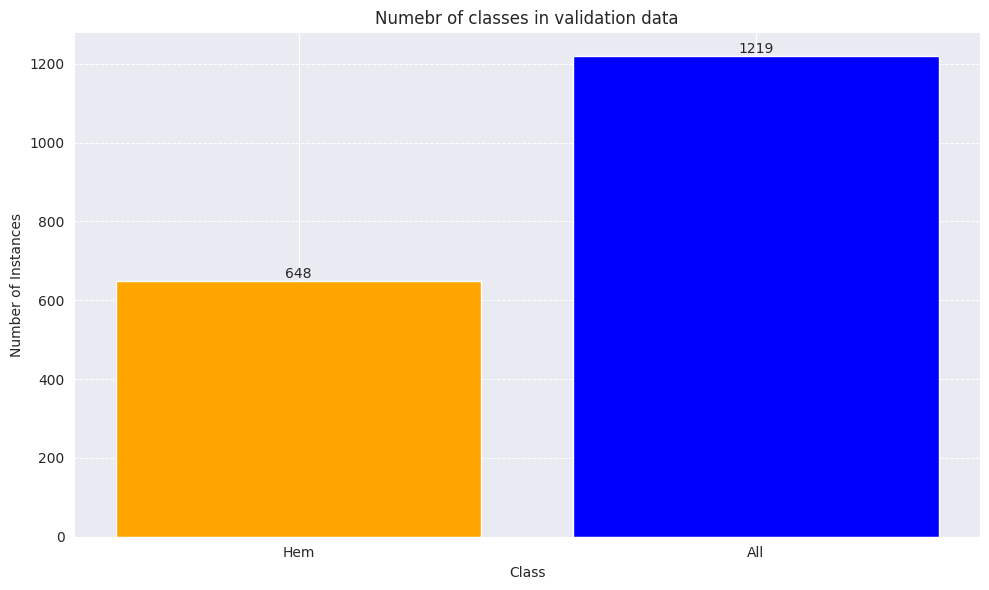

In [31]:
# Create a bar graph to show the distribution of classes with annotations and different colors
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'])

# Annotate the bars with the count of each class
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

# Set titles and labels
plt.title('Numebr of classes in validation data')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(ticks=[1, 0], labels=['All', 'Hem'], rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [13]:
# Initialize a dictionary to hold the count of each image size
size_counts = {}

# Loop through each fold and class, loading each image to get its size
for fold in ['fold_0', 'fold_1', 'fold_2']:
    fold_path = os.path.join(base_dir, fold)
    for class_name in ['all', 'hem']:
        class_path = os.path.join(fold_path, class_name)

        # Iterate over each image
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                with Image.open(image_path) as img:
                    # Get image size (width, height)
                    size = img.size

                    # Update the size count
                    if size not in size_counts:
                        size_counts[size] = 1
                    else:
                        size_counts[size] += 1

# Now size_counts dictionary contains all unique sizes and their respective counts
# You can print it out or analyze it as needed
print("Unique image sizes and their counts:")
for size, count in size_counts.items():
    print(f"Size: {size}, Count: {count}")


Unique image sizes and their counts:
Size: (450, 450), Count: 10661


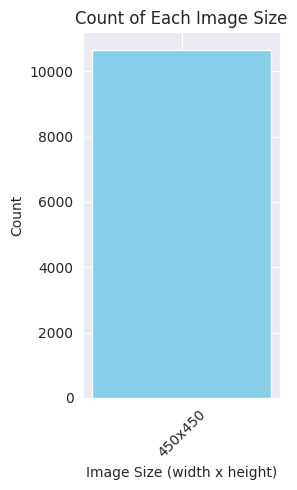

In [27]:
# Extract the image sizes and their counts
sizes = list(size_counts.keys())
counts = list(size_counts.values())

# Convert the size tuples to string labels
size_labels = [f"{w}x{h}" for w, h in sizes]

# Create a bar graph with a narrower bar width
plt.figure(figsize=(3, 5))
plt.bar(size_labels, counts, color='skyblue', width=0.4)  # Adjust the width here

# Add labels and title to the plot
plt.xlabel('Image Size (width x height)')
plt.ylabel('Count')
plt.title('Count of Each Image Size')
plt.xticks(rotation=45)  # Rotate the x-axis labels to fit longer labels

# Show the plot
plt.tight_layout()  # Adjust the layout to prevent clipping of tick-labels
plt.show()


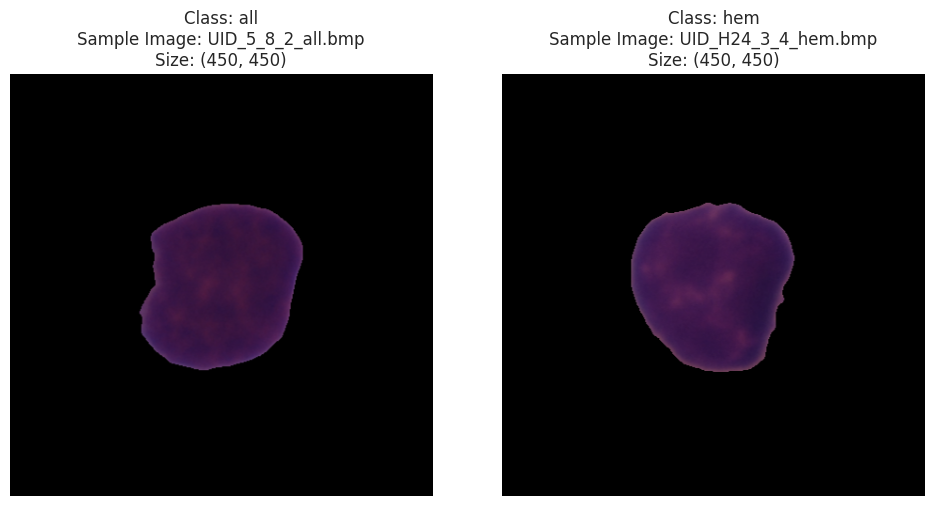

In [20]:
# Define the subdirectories for the classes
classes = ['all', 'hem']

# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# Iterate over the classes to load and display an image from each
for i, class_name in enumerate(classes):
    # Access the first image from each class in 'fold_0'
    class_path = os.path.join(base_dir, 'fold_0', class_name)
    sample_image_name = os.listdir(class_path)[0]  # Taking the first image in the directory
    sample_image_path = os.path.join(class_path, sample_image_name)

    # Load the image
    with Image.open(sample_image_path) as sample_image:
        # Add a subplot for each class
        plt.subplot(1, len(classes), i+1)
        plt.imshow(sample_image)
        plt.title(f'Class: {class_name}\nSample Image: {sample_image_name}\nSize: {sample_image.size}')
        plt.axis('off')  # Hide the axis

# Adjust the layout of the plots
plt.tight_layout()
plt.show()